In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt


## Calculate Magnetic field at position P

## New position

In [31]:
#R = 0.5
#A = [[0, 0.39], [0.39, math.pi+0.01], [math.pi+0.01, math.pi*2]]

def get_B(R, A, B, G, P):
    # Step 1: check what point it is
    x = P[0]
    y = P[1]

    # Initialize output
    Bout = 0
    # Update output, if needed

    for k in range(len(A)):
        
        m1 = math.tan(math.pi/2 - float(A[k][0]))
        m2 = math.tan(math.pi/2 - float(A[k][1]))
        
        if y < m1*x - R and y >= m2*x - R:  # if P is in Area k

            d = math.sqrt(x**2 + (y-(-R))**2)
            h = R - d
            Bout = float(B[k]) + float(G[k])*h
            break

 
    return Bout



def rot_matrix(alpha):
    R = np.array([[np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha), np.cos(alpha)]]) # Defining the rotation matrix in a clockwise direction
    return R


def next_point(r, P, D):
    
    s = 0.01

   
    pc = np.matmul(rot_matrix(-math.pi/2), D) # Multiplying the two matrices together to get the vector going from the point to the center
    pc = r *pc 

    Cx = P[0]+pc[0]
    Cy = P[1]+pc[1]
    c = np.array([Cx, Cy])
   
    CP = np.subtract(P, c) # Subtracting the center from the point to find CP
    theta = s/r
  
    CP2 = np.matmul(rot_matrix(-theta), CP)
    P2 = np.add(c,CP2) # Adding the distance from the center of the circle with the coordinates of the center to find the coordinates of the new point

    PC2 = -CP2
    D2 = np.matmul(rot_matrix(math.pi/2), PC2)

    # Compute the magnitude of the vector
    magnitude = np.linalg.norm(D2) 
    # Normalize the vector
    D2 = D2/magnitude  

   # D2 = np.array(D2)

    return P2, D2   




def get_points(R, A, B, G, P, D, Energy, size):

    # Compute the magnitude of the vector for normalization
    magnitude = np.linalg.norm(D) 
    # Normalize the vector
    eps = 1e-10
    D = D/(magnitude+eps) # Normalizing the vector and adding a tiny constant to avoid division by zero error

    B_e = 3.3356*(Energy/1000) # Beam Rigidity
    s = 0.01 # Step size

    points = []
    points.append([float(P[0]), float(P[1])])

    trajectory_len = float(size)
    num_steps = trajectory_len/s

    bending_radnius = []
    for i in range(int(num_steps)):
        Bout = get_B(R, A, B, G, P)
        if Bout != 0:
            bending_rad = B_e/abs(Bout) # Radius
        
            bending_radnius.append(R)
            P, D = next_point(bending_rad,P,D) # Calculating the next point
        else: # If the magnetic field is zero at this point the particle just continues in a straight line
            P2 = s*D
            P = np.add(P, P2)

        points.append(P)
    
     
    # Splitting the data into x and y coordinates for plotting
    x = [point[0] for point in points]
    y = [point[1] for point in points]


    return x,y, bending_radnius







def default2(A, li, R):
    """ This function creates the default preview that the user can see without having to input X_min, X_max, Y_min, Y_max"""


    # Default values for x_min, x_max, y_min, y_max
    X_min = -0.2
    X_max = R + 0.5
    Y_min = -R-0.2
    Y_max = 0.2
    a = 0 # X coordinate of center of circle
    b = -R # Y coordinate of center of circle
    stepSize = 0.01 # Stepsize of line of circle

    # This is to calculate the coordinates of the circles circumference
    positions = []
    t = 0
    while t < 2 * math.pi:
        positions.append((R*math.cos(t) + a, R*math.sin(t) + b))
        t += stepSize
    X = []
    Y = []
    for i in positions:
        x, y = i
        X.append(x)
        Y.append(y)

    # Initiating the plot
    fig, ax = plt.subplots(figsize=(10,10)) 
    # Adding the line to the plot
    ax.plot(X, Y, color='black')

    # This is to split the Vector into B and G
    d = dict()
    for i in range(len(li[0])):
        d[i] = []
        for j in range(len(li)):
            try:
                d[i].append(li[j][i])
            except IndexError:
                d[i].append(0)
    B = d[0]
    try:
        G = d[1]
    except KeyError: # If the user only input vector of size one, we just make G a vector of 0's
        G = []
        for i in range(len(li)):
            G.append(0)

    a = A # This is just to not confuse the old alpha with the "new"
    A = []
    curr = 0
    # This part calculates the beginning point and end point of alpha
    for i in range(len(a)):
        A.append([curr, curr + float(a[i])])
        curr += float(a[i])


    # This makes the coordinates of the points and initiates the magnetic field vector
    X = np.linspace(X_min, X_max, num=100)
    Y = np.linspace(Y_min, Y_max, num=100)
    xx, yy = np.meshgrid(X, Y)
    mag_field = np.zeros_like(xx)

    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            P = xx[i, j], yy[i, j] # Here we define the coordinates of the point
            mag_field[i, j] = get_B(R, A, B, G, P) # Here we calculate the magnetic field at position P

    color_mesh = ax.pcolormesh(xx, yy, mag_field, cmap='Reds') # This line makes the actual plot

    # This is just for customizing the look of the plot
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    colorbar = plt.colorbar(color_mesh, ax=ax)
    colorbar.set_label('Magnetic Field (T)')
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([X_min, X_max])
    ax.set_ylim([Y_min, Y_max])
    

    directions = ["1, 0", "1, 0", "1, 0"]
    positions = ["0, 0", "0, 0","0, 0"]
    Energy = [100,120,140]


    for i in range(len(positions)):

        parts = positions[i].split(',')
        pos = [float(part) for part in parts]
        
        parts = directions[i].split(',')
        dir = [float(part) for part in parts]

        x,y,bending_radius = get_points(R, A, B, G, [pos[0],pos[1]], [dir[0],dir[1]], Energy[i], 4)   
        plt.plot(x,y)


    return fig,ax,bending_radius







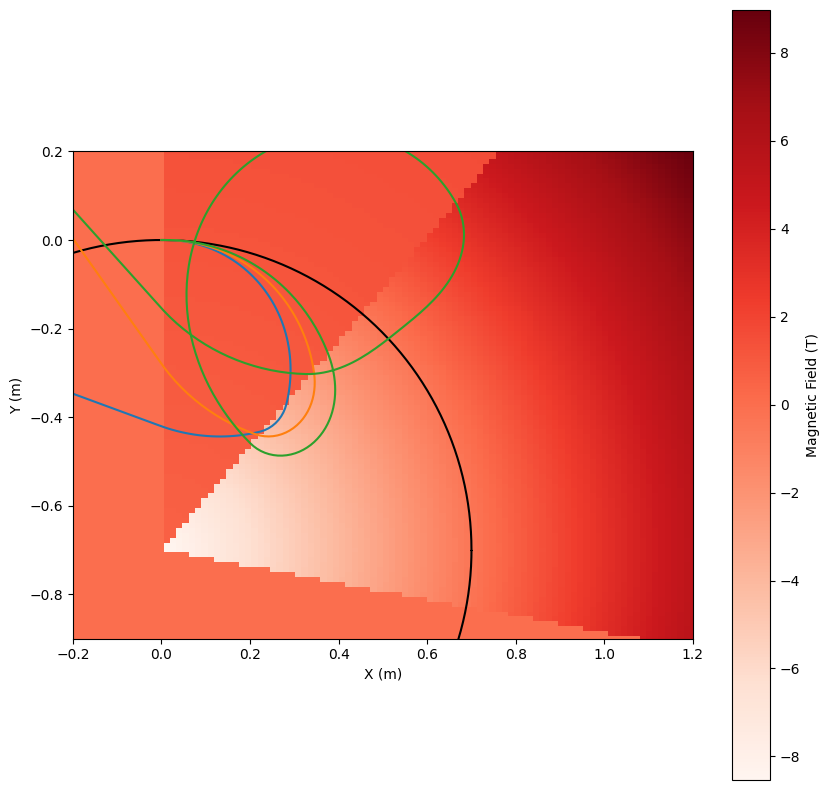

In [32]:


li = [[1.21605747, -0.85671993],[ -0.44208197, -11.76605932]]
A = [0.70220476, 1.05240451]
R = 0.7

fig,ax,bending_radius = default2(A, li, R)


## Generating Energy files

In [6]:
import numpy as np

N = [10,100,1000,10000]

for i in N:
    mu, sigma = 100, 0 # mean and standard deviation
    s = np.random.normal(mu, sigma, N)
    print(s)
    break

In [2]:
import numpy as np

In [92]:
d = {'Energies': {'file1': [[100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0]], 'file2': [[120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0]], 'file3': [[140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0]]}, 'Positions': {'file1': [[-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0]], 'file2': [[-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0]], 'file3': [[-0.2, 0.0], [-0.2, 0.0003497493256804], [-0.2, -0.0006763386816988], [-0.2, 0.0005203743344812], [-0.2, -0.0023851000750595], [-0.2, 0.0003793495454163], [-0.2, -0.0006455781596964], [-0.2, -8.73075635697755e-05], [-0.2, -0.0019387082730754], [-0.2, -0.0004675495886132]]}, 'Directions': {'file1': [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], 'file2': [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], 'file3': [[1.0, 0.0], [0.999998875000211, -0.0014999994375], [0.999999367187567, -0.0011249997626953], [0.999999718750013, -0.0007499999296875], [0.999999929687501, -0.0003749999912109], [1.0, 0.0], [0.999999929687501, 0.0003749999912109], [0.999999718750013, 0.0007499999296875], [0.999999367187567, 0.0011249997626953], [0.999998875000211, 0.0014999994375]]}}


In [93]:
def calculate_averages(file_data):
    averages = {"Positions": {}, "Directions": {}, "Energies": {}}

    for category, category_dict in file_data.items():
        for file, file_data_list in category_dict.items():
            if category == "Energies":
                # For 'Energies', calculate the average of all values
                averages[category][file] = sum(val[0] for val in file_data_list) / len(file_data_list)
            else:
                # For 'Positions' and 'Directions', calculate the average of corresponding values
                averages[category][file] = [sum(val[i] for val in file_data_list) / len(file_data_list) for i in range(len(file_data_list[0]))]

    return averages


averages = calculate_averages(d)
print(averages)


{'Positions': {'file1': [-0.19999999999999998, 0.0], 'file2': [-0.19999999999999998, 0.0], 'file3': [-0.19999999999999998, -0.0004951109136135175]}, 'Directions': {'file1': [1.0, 0.0], 'file2': [1.0, 0.0], 'file3': [0.9999995781250585, 0.0]}, 'Energies': {'file1': 100.0, 'file2': 120.0, 'file3': 140.0}}


In [95]:
file_keys = set(key for category_dict in averages.values() for key in category_dict.keys())

for file in file_keys:
    position = averages['Positions'].get(file)
    direction = averages['Directions'].get(file)
    energy = averages['Energies'].get(file)


    x,y = get_points(R, A, B, G, [position[0],position[1]], [direction[0],direction[1]], energy, Pages.tracking)  # Plotting the beam
    plt.plot(x,y)

    print(position[0])

-0.19999999999999998
-0.19999999999999998
-0.19999999999999998


In [91]:
for key, value in averages.items():
    for k in in key.:
        print(k)

SyntaxError: invalid syntax (2553991894.py, line 2)

In [ ]:
{'Energies': {'file1': [[100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0], [100.0]], 'file2': [[120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0], [120.0]], 'file3': [[140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0], [140.0]]}, 'Positions': {'file1': [[-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0]], 'file2': [[-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0], [-0.2, 0.0]], 'file3': [[-0.2, 0.0], [-0.2, 0.0003497493256804], [-0.2, -0.0006763386816988], [-0.2, 0.0005203743344812], [-0.2, -0.0023851000750595], [-0.2, 0.0003793495454163], [-0.2, -0.0006455781596964], [-0.2, -8.73075635697755e-05], [-0.2, -0.0019387082730754], [-0.2, -0.0004675495886132]]}, 'Directions': {'file1': [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], 'file2': [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], 'file3': [[1.0, 0.0], [0.999998875000211, -0.0014999994375], [0.999999367187567, -0.0011249997626953], [0.999999718750013, -0.0007499999296875], [0.999999929687501, -0.0003749999912109], [1.0, 0.0], [0.999999929687501, 0.0003749999912109], [0.999999718750013, 0.0007499999296875], [0.999999367187567, 0.0011249997626953], [0.999998875000211, 0.0014999994375]]}}
